In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [123]:
!pip install emoji umap-learn

     |████████████████████████████████| 69 kB 1.9 MB/s eta 0:00:011
     |████████████████████████████████| 3.1 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 25.3 MB 11.6 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.4.6-py3-none-any.whl size=67950 sha256=222908fb673dbb888743be4eea0db343dc41190b75db0740a4b669e3d329aece
  Stored in directory: /root/.cache/pip/wheels/22/ce/3d/75f6600b4d93c851021aceeec51b7b330c0ad4d9692e69be6a
Successfully built umap-learn
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [174]:
import pandas as pd
import tensorflow as tf
from transformers import TFAutoModel
from transformers import BertweetTokenizer
import tensorflow_hub as hub

In [17]:
tokenizer = BertweetTokenizer.from_pretrained("vinai/bertweet-base", normalization=True)
bertweet = TFAutoModel.from_pretrained("vinai/bertweet-base")
bertweet.trainable=False

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [6]:
training = pd.read_csv('../data/external/kaggle/train.csv')
training

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [181]:
tokenizer.tokenize('😃😊🥺😉😍😘🥰🇫🇷')

[':grinning_face_with_big_eyes:',
 ':smiling_face_with_smiling_eyes:',
 ':pleading_face:',
 ':winking_face:',
 ':smiling_face_with_heart-eyes:',
 ':face_blowing_a_kiss:',
 ':smiling_face_with_3_hearts:',
 ':regional_indicator_symbol_letter_f:',
 ':regional_indicator_symbol_letter_r:']

In [42]:
to_tokenize = training['text'].values

In [87]:
%%time
tokenized = tokenizer(list(to_tokenize), padding=True, truncation=True, return_tensors='tf', return_token_type_ids=False)
inputs = tokenized['input_ids']
masks = tokenized['attention_mask']

CPU times: user 1.79 s, sys: 2.9 ms, total: 1.8 s
Wall time: 1.79 s


In [113]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, masks))
dataset = dataset.batch(512)

In [126]:
%%time
embeddings = []
for input_tensor, attention_mask in dataset:
    output = bertweet([input_tensor, attention_mask])
    embeddings.append(output.pooler_output.numpy())

CPU times: user 9.22 s, sys: 2.94 s, total: 12.2 s
Wall time: 10.1 s


In [130]:
bertweet_embeddings = np.vstack(embeddings)

In [171]:
with open('../data/interim/bertweet_embeddings.npy', 'wb') as f:
    np.save(f, bertweet_embeddings)

In [124]:
import umap

In [125]:
reducer = umap.UMAP()

In [137]:
%%time
embeddings = reducer.fit_transform(bertweet_embeddings, y=training['target'].values)
embeddings

CPU times: user 3min 27s, sys: 7.89 s, total: 3min 35s
Wall time: 13.5 s


array([[-26.522089, -11.803437],
       [-28.014124, -11.688177],
       [-28.004717, -11.274336],
       ...,
       [-26.207136, -10.185058],
       [-29.109596, -12.59923 ],
       [-22.209097, -10.01638 ]], dtype=float32)

In [173]:
with open('../data/interim/bertweet_2d.npy', 'wb') as f:
    np.save(f, embeddings)

In [139]:
!pip install seaborn

     |████████████████████████████████| 283 kB 2.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [140]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib notebook

<IPython.core.display.Javascript object>


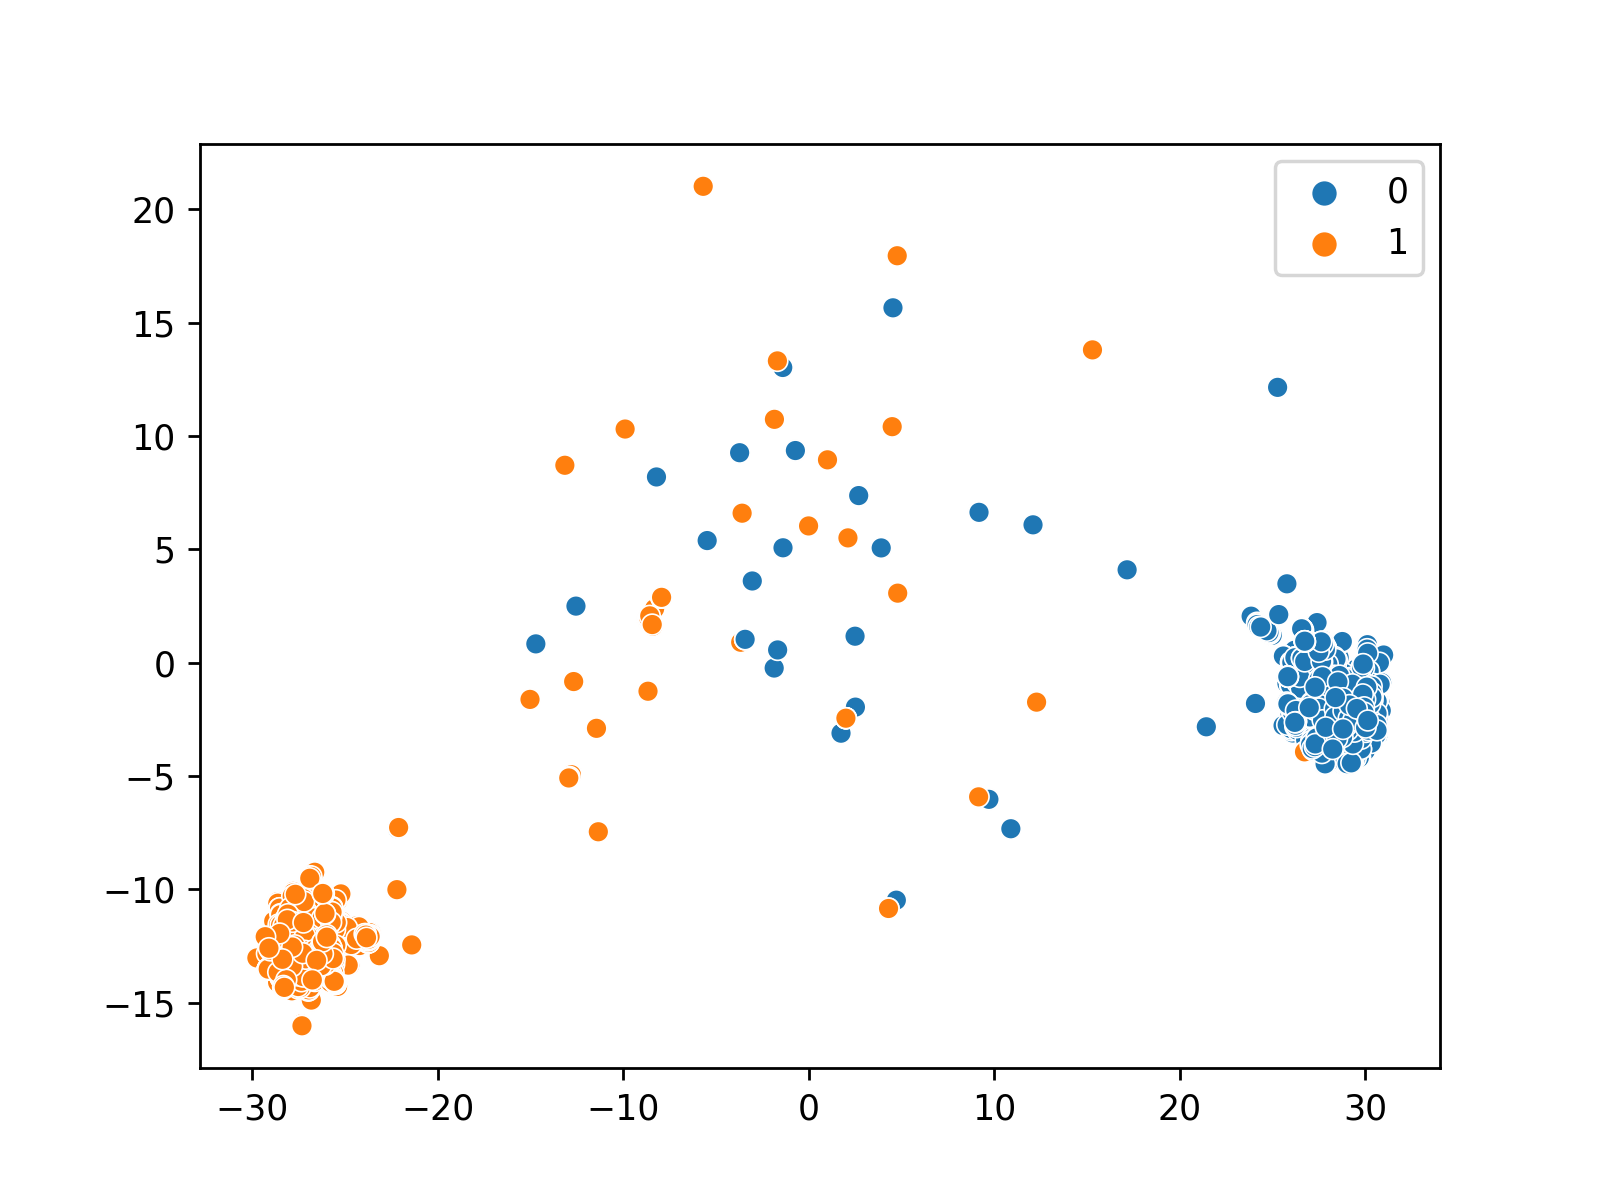

<AxesSubplot:>

In [164]:
sns.scatterplot(x=embeddings[:, 0],y=embeddings[:, 1], hue=training['target'].values)

In [145]:
use_4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 180.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 360.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 540.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 720.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 900.00MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


In [153]:
dataset = tf.data.Dataset.from_tensor_slices(training['text'].values)
dataset = dataset.batch(512)

In [155]:
%%time
use_4_embeddings = []
for batch in dataset:
    embedding = use_4(batch)
    use_4_embeddings.append(embedding.numpy())

CPU times: user 1.13 s, sys: 154 ms, total: 1.28 s
Wall time: 762 ms


In [159]:
use_4_embeddings = np.vstack(use_4_embeddings)

In [168]:
with open('../data/interim/use_4_embeddings.npy', 'wb') as f:
    np.save(f, use_4_embeddings)

In [167]:
pd.DataFrame(use_4_embeddings).describe()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
count,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,...,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,0.006440,0.000468,0.001094,-0.011119,0.001760,-0.006898,0.014011,0.001551,-0.001298,0.001467,...,0.003915,0.037033,0.017084,-0.006014,0.014411,-0.004550,-0.006057,-0.003550,-0.012355,-0.016288
std,0.035848,0.044268,0.043611,0.035363,0.041267,0.046759,0.039416,0.037247,0.046831,0.045562,...,0.040307,0.035084,0.039089,0.044327,0.042863,0.044042,0.034011,0.034968,0.045043,0.043079
min,-0.092729,-0.115320,-0.093244,-0.095986,-0.114965,-0.124695,-0.096176,-0.101010,-0.138879,-0.113590,...,-0.113661,-0.160975,-0.097579,-0.112683,-0.102550,-0.101346,-0.100831,-0.088056,-0.105996,-0.113714
25%,-0.019803,-0.035574,-0.034021,-0.038973,-0.029595,-0.047246,-0.014707,-0.026546,-0.038323,-0.034110,...,-0.026728,0.021750,-0.011281,-0.039634,-0.015793,-0.041217,-0.031313,-0.030265,-0.049790,-0.054201
50%,0.007162,0.001639,-0.001139,-0.013299,0.003865,-0.007116,0.017701,-0.000526,0.001939,0.003327,...,0.005055,0.045423,0.019667,-0.002954,0.020411,-0.006632,-0.007204,-0.004313,-0.017687,-0.014813
75%,0.034013,0.036856,0.033701,0.014203,0.034317,0.030509,0.045031,0.028070,0.036124,0.039259,...,0.036355,0.061570,0.048022,0.028850,0.048265,0.029348,0.018987,0.021619,0.020219,0.018099
max,0.112639,0.100085,0.115811,0.091170,0.112800,0.104831,0.102043,0.119822,0.108581,0.104164,...,0.095795,0.112709,0.117328,0.091763,0.098099,0.112419,0.089928,0.099583,0.120463,0.088264


In [161]:
%%time
use_4_reducer = umap.UMAP()
use_4_reduced = reducer.fit_transform(use_4_embeddings, y=training['target'].values)
use_4_reduced

CPU times: user 2min 49s, sys: 4.12 s, total: 2min 53s
Wall time: 9.96 s


array([[17.12013  ,  9.501081 ],
       [12.296554 ,  6.3889794],
       [12.84499  ,  7.049571 ],
       ...,
       [13.066819 ,  9.948728 ],
       [15.133787 ,  7.013269 ],
       [11.311649 ,  6.241236 ]], dtype=float32)

In [169]:
with open('../data/interim/use_4_2d.npy', 'wb') as f:
    np.save(f, use_4_reduced)

<IPython.core.display.Javascript object>


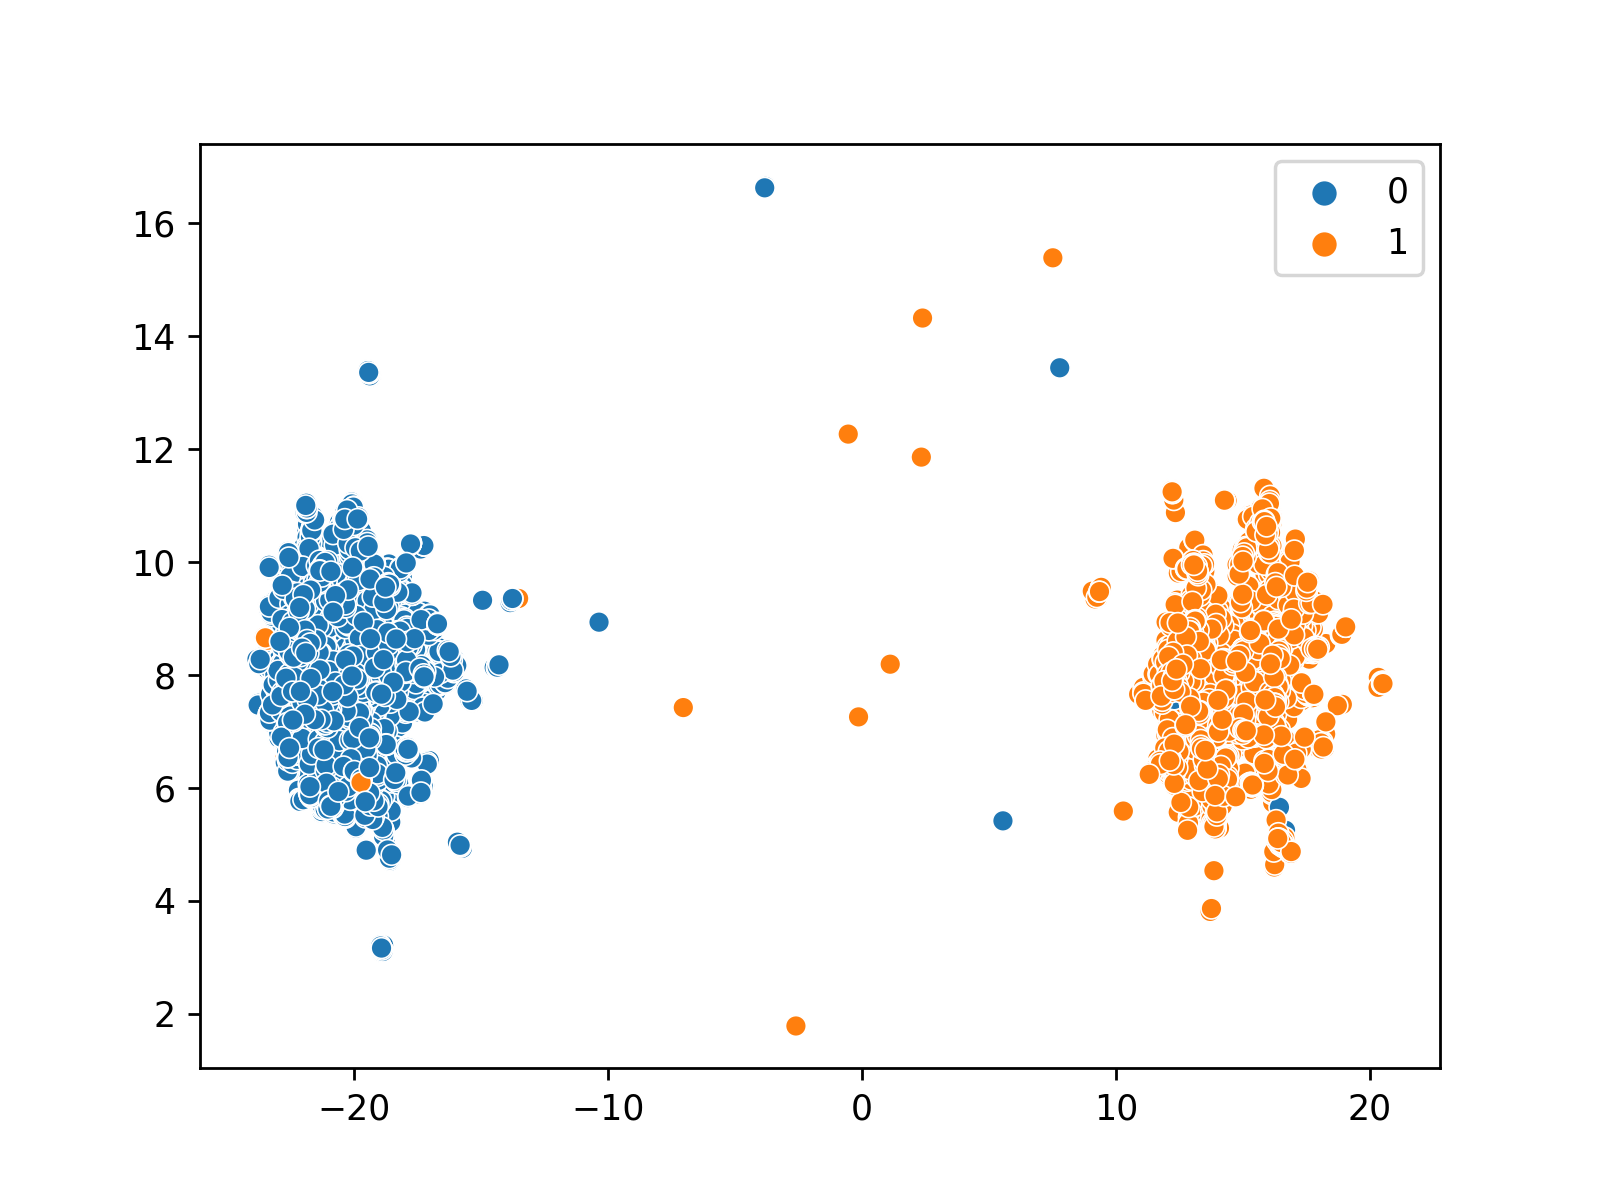

<AxesSubplot:>

In [165]:
sns.scatterplot(x=use_4_reduced[:, 0],y=use_4_reduced[:, 1], hue=training['target'].values)

In [182]:
appen_training = pd.read_csv('../data/external/appen/disaster_response_messages_training.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [185]:
appen_training['genre'].value_counts()

news      10450
direct     8666
social     1930
Name: genre, dtype: int64

In [186]:
appen_training

,id,split,message,original,genre,related,PII,request,offer,aid_related,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21041,30261,train,The training demonstrated how to enhance micro...,NaN,news,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21042,30262,train,A suitable candidate has been selected and OCH...,NaN,news,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21043,30263,train,"Proshika, operating in Cox's Bazar municipalit...",NaN,news,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21044,30264,train,"Some 2,000 women protesting against the conduc...",NaN,news,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
